In [1]:
## conda install -c conda-forge python-engineio=2.2.0
## conda env create -f environment.yml

# packages
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import cv2
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Flatten,Dense,Lambda,Dropout
from tensorflow.keras.optimizers import Adam
import h5py

from tensorflow.keras.models import load_model
from keras.callbacks import ModelCheckpoint



## Step 1: Initialize Data

In [2]:
# functions

# TO REMOVE FILE PATH AND GET ONLY FILE NAME
def getName(filePath):
    return filePath.split('\\')[-1]
 
                          
# To Import the data from the simulation then remove the path of the Center
def importDataInfo(path):
    columns = ['Center', 'Left', 'Right', 'Steering', 'Throttle', 'Brake', 'Speed']
    data = pd.read_csv(os.path.join(path, 'driving_log.csv'), names = columns)
    #### REMOVE FILE PATH AND GET ONLY FILE NAME
    #print(getName(data['center'][0]))
    data['Center']=data['Center'].apply(getName)
    #print(data.head())
    print('Total Images Imported',data.shape[0])
    return data

In [3]:
path = 'Data'
data = importDataInfo(path)

Total Images Imported 5649


In [4]:
data.head()

,Center,Left,Right,Steering,Throttle,Brake,Speed
0,center_2022_03_17_18_16_25_093.jpg,D:\Work\Graduation Project 2\term 1\beta_simul...,D:\Work\Graduation Project 2\term 1\beta_simul...,0.0,0.0,0,17.82055
1,center_2022_03_17_18_16_25_166.jpg,D:\Work\Graduation Project 2\term 1\beta_simul...,D:\Work\Graduation Project 2\term 1\beta_simul...,0.0,0.0,0,17.67991
2,center_2022_03_17_18_16_25_242.jpg,D:\Work\Graduation Project 2\term 1\beta_simul...,D:\Work\Graduation Project 2\term 1\beta_simul...,0.0,0.0,0,17.54029
3,center_2022_03_17_18_16_25_310.jpg,D:\Work\Graduation Project 2\term 1\beta_simul...,D:\Work\Graduation Project 2\term 1\beta_simul...,0.0,0.0,0,16.90164
4,center_2022_03_17_18_16_25_378.jpg,D:\Work\Graduation Project 2\term 1\beta_simul...,D:\Work\Graduation Project 2\term 1\beta_simul...,0.0,0.0,0,17.33289


## Step 2: Visualize and Balance Data

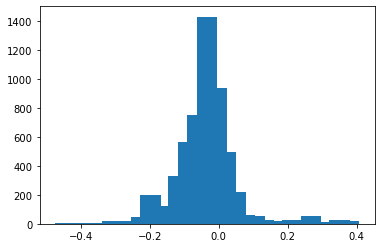

In [5]:
nBin = 31
hist, bins = np.histogram(data['Steering'], nBin)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.06)
plt.show()

In [6]:
# functions

def balanceData(data, samplesPerBin ,display=True):
    nBin = 31
    hist, bins = np.histogram(data['Steering'], nBin)
    center = (bins[:-1] + bins[1:]) * 0.5

    if display:
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()
        
    
    removeindexList = []
    for j in range(nBin):
        binDataList = []
        for i in range(len(data['Steering'])):
            if data['Steering'][i] >= bins[j] and data['Steering'][i] <= bins[j + 1]:
                binDataList.append(i)
        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplesPerBin:]
        removeindexList.extend(binDataList)
 
    print('Removed Images:', len(removeindexList))
    data.drop(data.index[removeindexList], inplace=True)
    print('Remaining Images:', len(data))
    
    
    if display:
        hist, _ = np.histogram(data['Steering'], (nBin))
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()


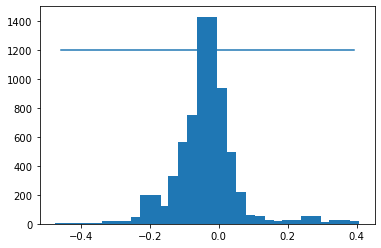

Removed Images: 233
Remaining Images: 5416


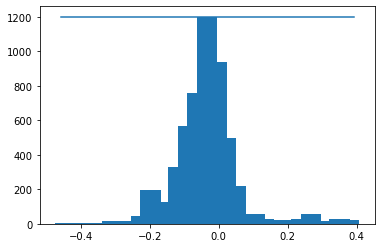

In [7]:
balanceData(data , 1200)
#data = balanceData(data, 500 ,display=False)

## Step 3: Prepare for processing

In [8]:
## getting (imagesPath, steerings)

def loadData(path, data):
    imagesPath = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        imagesPath.append(f'{path}/IMG/{indexed_data[0]}')
        steering.append(float(indexed_data[3]))
    imagesPath = np.asarray(imagesPath)
    steering = np.asarray(steering)
    return imagesPath, steering

In [9]:
imagesPath, steerings = loadData(path, data)

## Step 4: Split for Training and Validation

In [10]:
xTrain, xVal, yTrain, yVal = train_test_split(imagesPath, steerings, test_size=0.2,random_state=10)

print('Total Training Images: ',len(xTrain))
print('Total Validation Images: ',len(xVal))

Total Training Images:  4332
Total Validation Images:  1084


## Step 5: Data Augmentation

In [11]:
# functions

def augmentImage(imgPath,steering):
    img =  mpimg.imread(imgPath)
    
    # Pan
    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
        img = pan.augment_image(img)
        
    # Zoom
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)
        
    # Brightness
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.2, 1.2))
        img = brightness.augment_image(img)
        
    # Flip
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        steering = -steering
    return img, steering

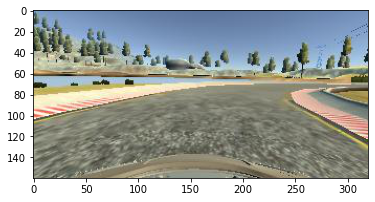

In [12]:
imgPath = 'test.jpg'
img_orig =  mpimg.imread(imgPath)
plt.imshow(img_orig)
plt.show()

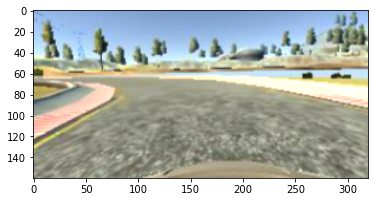

In [13]:
img_aug, steering = augmentImage(imgPath, 0.5)

plt.imshow(img_aug)
plt.show()

## Step 6: Data Preprocessing

In [14]:
# functions

def preProcess(img ,display=False):
    
    if display:
        print("Original:")
        plt.imshow(img)
        plt.show()
    
    
    
    ## Cropping
    img = img[60:135,:,:]
    
    if display:
        print("1- Crop:")
        plt.imshow(img)
        plt.show()
    
    
    
    ## YUV Colorspace
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    
    if display:
        print("2- YUV Colorspace:")
        plt.imshow(img)
        plt.show()    
    
    
    
    ## Blur
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    
    if display:
        print("3- Blur:")
        plt.imshow(img)
        plt.show()     
    
    
    
    ## Resize
    img = cv2.resize(img, (200, 66))
    
    if display:
        print("4- Resize:")
        plt.imshow(img)
        plt.show() 
        
        
        
    ## Rescale
    img = img/255
    
    
    if display:
        print("5- Rescale:")
        plt.imshow(img)
        plt.show() 
        
        
    return img



Original:


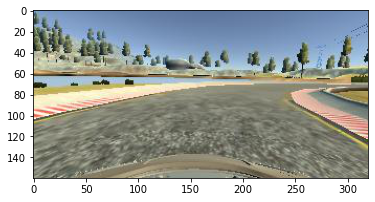

1- Crop:


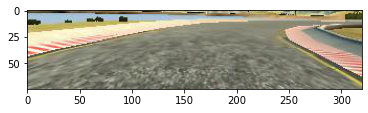

2- YUV Colorspace:


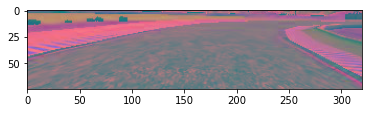

3- Blur:


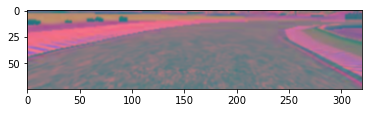

4- Resize:


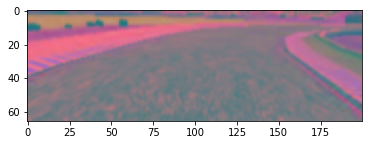

5- Rescale:


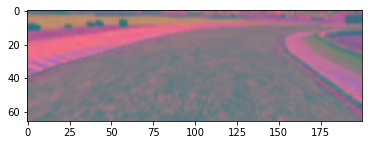

In [15]:

img = preProcess(img_orig ,display=True)


## Step 7: Batch Generator

In [16]:
# functions

def batchGen(imagesPath, steeringList, batchSize, trainFlag):
    while True:
        imgBatch = []
        steeringBatch = []

        for i in range(batchSize):
            # choose random image
            index = random.randint(0, len(imagesPath) - 1)
            
            
            
            # Augment Images for training set only
            if trainFlag:
                img, steering = augmentImage(imagesPath[index], steeringList[index])
            else:
                img = mpimg.imread(imagesPath[index])
                steering = steeringList[index]
            
            # PreProcess Images
            img = preProcess(img)
            
            imgBatch.append(img)
            steeringBatch.append(steering)
            
        yield (np.asarray(imgBatch),np.asarray(steeringBatch))

## Step 8: Creating the Model


In [17]:
# to remove wornings
print('Setting UP')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Setting UP


In [18]:
# Self Driving Simulation using CNN NVIDIA's MODEL Tensorflow (2020)

def createModel():
    model = Sequential()
    #model.add(Lambda(lambda x: x/127.5-1.0, input_shape=(66, 200, 3)))
    model.add(Convolution2D(24, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(36, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(48, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    #model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation = 'elu'))
    model.add(Dense(50, activation = 'elu'))
    model.add(Dense(10, activation = 'elu'))
    model.add(Dense(1))
    return model

In [19]:
model = createModel()
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [ ]:
# model = load_model('model4_A.h5')

In [20]:
# Self Driving Simulation using CNN NVIDIA's MODEL Tensorflow (2020)


def createModel():
    model = Sequential()
    model.add(Convolution2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(48, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
 
    model.add(Flatten())
    model.add(Dense(100, activation = 'elu'))
    model.add(Dense(50, activation = 'elu'))
    model.add(Dense(10, activation = 'elu'))
    model.add(Dense(1))
 
    model.compile(Adam(lr=0.0001),loss='mse')
    return model

In [21]:
model = createModel()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 dense_4 (Dense)             (None, 100)              

C:\Users\Andrew\anaconda3\envs\PyQt5\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Step 9: Train the Model


In [25]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')



history = model.fit(batchGen(xTrain,yTrain,100,True) , steps_per_epoch= 300 , epochs= 30 , 
                    validation_data= batchGen(xVal , yVal ,100 , False)
                   , validation_steps= 200)

Epoch 1/30
300/300 [==============================] - 384s 1s/step - loss: 0.0033 - val_loss: 0.0021
Epoch 2/30
300/300 [==============================] - 295s 983ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 3/30
300/300 [==============================] - 291s 971ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 4/30
300/300 [==============================] - 292s 976ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 5/30
300/300 [==============================] - 297s 992ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 6/30
300/300 [==============================] - 293s 978ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 7/30
300/300 [==============================] - 289s 966ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 8/30
300/300 [==============================] - 289s 966ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 9/30
300/300 [==============================] - 289s 966ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 10/30
300/300 [==============================] - 289s 966ms/s

## Step 10: Save and Plot the Model


In [31]:
import h5py
model.save('model_o3.h5')
print('Model Saved')

Model Saved


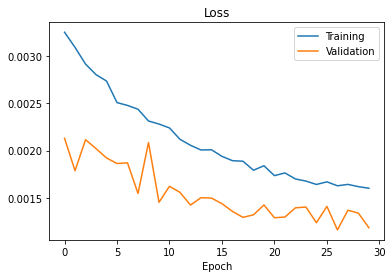

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

#plt.ylim([0,1])
plt.legend(['Training','Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

In [28]:
history2 = model.fit(batchGen(xTrain,yTrain,100,True) , steps_per_epoch= 300 , epochs= 30 , 
                    validation_data= batchGen(xVal , yVal ,100 , False)
                   , validation_steps= 200)

Epoch 1/30
300/300 [==============================] - 297s 992ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 2/30
300/300 [==============================] - 296s 988ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 3/30
300/300 [==============================] - 291s 971ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 4/30
300/300 [==============================] - 299s 999ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 5/30
300/300 [==============================] - 304s 1s/step - loss: 0.0015 - val_loss: 0.0011
Epoch 6/30
300/300 [==============================] - 300s 1s/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/30
300/300 [==============================] - 297s 990ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 8/30
300/300 [==============================] - 291s 971ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 9/30
300/300 [==============================] - 302s 1s/step - loss: 0.0015 - val_loss: 0.0010
Epoch 10/30
300/300 [==============================] - 298s 996ms/step - 

In [ ]:
import h5py
model.save('model_o4.h5')
print('Model Saved')

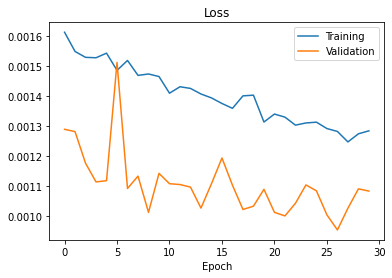

In [32]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

#plt.ylim([0,1])
plt.legend(['Training','Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

In [33]:
history2 = model.fit(batchGen(xTrain,yTrain,100,True) , steps_per_epoch= 300 , epochs= 10 , 
                    validation_data= batchGen(xVal , yVal ,100 , False)
                   , validation_steps= 200)

Epoch 1/10
300/300 [==============================] - 449s 1s/step - loss: 0.0013 - val_loss: 9.7827e-04
Epoch 2/10
300/300 [==============================] - 296s 988ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 3/10
300/300 [==============================] - 349s 1s/step - loss: 0.0012 - val_loss: 0.0010
Epoch 4/10
300/300 [==============================] - 406s 1s/step - loss: 0.0012 - val_loss: 9.0722e-04
Epoch 5/10
300/300 [==============================] - 304s 1s/step - loss: 0.0012 - val_loss: 9.9186e-04
Epoch 6/10
300/300 [==============================] - 5618s 19s/step - loss: 0.0012 - val_loss: 9.3953e-04
Epoch 7/10
300/300 [==============================] - 346s 1s/step - loss: 0.0012 - val_loss: 9.3441e-04
Epoch 8/10
300/300 [==============================] - 302s 1s/step - loss: 0.0012 - val_loss: 0.0010
Epoch 9/10
300/300 [==============================] - 304s 1s/step - loss: 0.0012 - val_loss: 9.0106e-04
Epoch 10/10
300/300 [==============================] - 332s 1s

In [34]:
import h5py
model.save('model_o5.h5')
print('Model Saved')

Model Saved


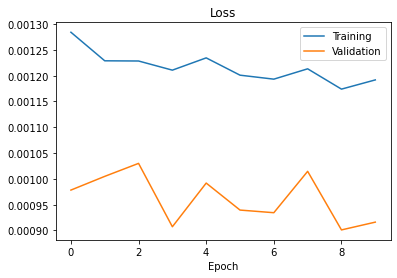

In [35]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

#plt.ylim([0,1])
plt.legend(['Training','Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

In [40]:
history2 = model.fit(batchGen(xTrain,yTrain,32,True) , steps_per_epoch= 300 , epochs= 100 , 
                    validation_data= batchGen(xVal , yVal ,100 , False)
                   , validation_steps= 50)

Epoch 1/100
300/300 [==============================] - 94s 312ms/step - loss: 0.0013 - val_loss: 9.7253e-04
Epoch 2/100
300/300 [==============================] - 96s 320ms/step - loss: 0.0015 - val_loss: 8.9922e-04
Epoch 3/100
300/300 [==============================] - 100s 333ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/100
300/300 [==============================] - 100s 335ms/step - loss: 0.0013 - val_loss: 8.3215e-04
Epoch 5/100
300/300 [==============================] - 96s 320ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 6/100
300/300 [==============================] - 97s 324ms/step - loss: 0.0013 - val_loss: 8.8513e-04
Epoch 7/100
300/300 [==============================] - 97s 322ms/step - loss: 0.0012 - val_loss: 9.9151e-04
Epoch 8/100
300/300 [==============================] - 95s 317ms/step - loss: 0.0013 - val_loss: 9.7260e-04
Epoch 9/100
300/300 [==============================] - 97s 325ms/step - loss: 0.0012 - val_loss: 9.4790e-04
Epoch 10/100
300/300 [============

300/300 [==============================] - 99s 330ms/step - loss: 0.0011 - val_loss: 8.9600e-04
Epoch 77/100
300/300 [==============================] - 98s 326ms/step - loss: 0.0011 - val_loss: 7.4077e-04
Epoch 78/100
300/300 [==============================] - 105s 350ms/step - loss: 0.0010 - val_loss: 8.2195e-04
Epoch 79/100
300/300 [==============================] - 100s 332ms/step - loss: 0.0011 - val_loss: 8.8438e-04
Epoch 80/100
300/300 [==============================] - 92s 308ms/step - loss: 0.0010 - val_loss: 7.6009e-04
Epoch 81/100
300/300 [==============================] - 93s 311ms/step - loss: 0.0010 - val_loss: 7.7371e-04
Epoch 82/100
300/300 [==============================] - 92s 306ms/step - loss: 9.9855e-04 - val_loss: 7.3670e-04
Epoch 83/100
300/300 [==============================] - 93s 310ms/step - loss: 0.0011 - val_loss: 8.5195e-04
Epoch 84/100
300/300 [==============================] - 95s 316ms/step - loss: 0.0011 - val_loss: 7.7213e-04
Epoch 85/100
300/300 [====

In [41]:
import h5py
model.save('model_o7.h5')
print('Model Saved')

Model Saved


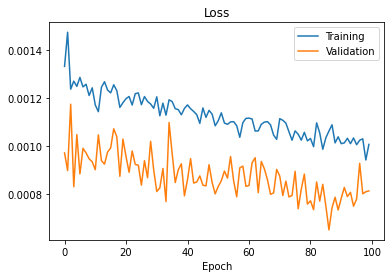

In [42]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

#plt.ylim([0,1])
plt.legend(['Training','Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

In [43]:
history2 = model.fit(batchGen(xTrain,yTrain,64,True) , steps_per_epoch= 300 , epochs= 100 , 
                    validation_data= batchGen(xVal , yVal ,100 , False)
                   , validation_steps= 50)

Epoch 1/100
300/300 [==============================] - 169s 563ms/step - loss: 9.4130e-04 - val_loss: 6.9118e-04
Epoch 2/100
300/300 [==============================] - 167s 558ms/step - loss: 9.0150e-04 - val_loss: 6.9719e-04
Epoch 3/100
300/300 [==============================] - 165s 551ms/step - loss: 9.1042e-04 - val_loss: 6.9434e-04
Epoch 4/100
300/300 [==============================] - 165s 551ms/step - loss: 9.0344e-04 - val_loss: 7.3801e-04
Epoch 5/100
300/300 [==============================] - 165s 552ms/step - loss: 9.1531e-04 - val_loss: 7.5566e-04
Epoch 6/100
300/300 [==============================] - 165s 552ms/step - loss: 9.4381e-04 - val_loss: 7.5257e-04
Epoch 7/100
300/300 [==============================] - 165s 549ms/step - loss: 8.9960e-04 - val_loss: 7.2778e-04
Epoch 8/100
300/300 [==============================] - 166s 555ms/step - loss: 8.9873e-04 - val_loss: 6.7159e-04
Epoch 9/100
300/300 [==============================] - 165s 552ms/step - loss: 9.2052e-04 - val_

Epoch 73/100
300/300 [==============================] - 167s 557ms/step - loss: 7.5551e-04 - val_loss: 6.2974e-04
Epoch 74/100
300/300 [==============================] - 166s 553ms/step - loss: 7.9304e-04 - val_loss: 5.9881e-04
Epoch 75/100
300/300 [==============================] - 166s 553ms/step - loss: 7.5497e-04 - val_loss: 5.9487e-04
Epoch 76/100
300/300 [==============================] - 168s 562ms/step - loss: 7.8238e-04 - val_loss: 6.1777e-04
Epoch 77/100
300/300 [==============================] - 165s 552ms/step - loss: 7.7667e-04 - val_loss: 5.6602e-04
Epoch 78/100
300/300 [==============================] - 170s 569ms/step - loss: 7.9601e-04 - val_loss: 6.2762e-04
Epoch 79/100
300/300 [==============================] - 166s 553ms/step - loss: 7.6643e-04 - val_loss: 5.9962e-04
Epoch 80/100
300/300 [==============================] - 166s 555ms/step - loss: 7.6202e-04 - val_loss: 6.2966e-04
Epoch 81/100
300/300 [==============================] - 166s 552ms/step - loss: 7.7842e-

In [44]:
import h5py
model.save('model_o8.h5')
print('Model Saved')

Model Saved


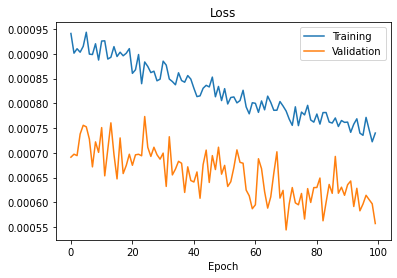

In [45]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

#plt.ylim([0,1])
plt.legend(['Training','Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

In [47]:
history2 = model.fit(batchGen(xTrain,yTrain,32,True) , steps_per_epoch= 100 , epochs= 100 , 
                    validation_data= batchGen(xVal , yVal ,100 , False)
                   , validation_steps= 50)

Epoch 1/100
100/100 [==============================] - 128s 1s/step - loss: 8.3417e-04 - val_loss: 7.3029e-04
Epoch 2/100
100/100 [==============================] - 127s 1s/step - loss: 8.3165e-04 - val_loss: 7.7059e-04
Epoch 3/100
 33/100 [========>.....................] - ETA: 51s - loss: 8.0914e-04

KeyboardInterrupt: 

In [ ]:
import h5py
model.save('model_o9.h5')
print('Model Saved')

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

#plt.ylim([0,1])
plt.legend(['Training','Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()